## Description
Our group has developed a regressor that predicts the ASR given certain values, here is a sample of the table used for said prediction:
|cluster_sdi|country|year|risk|ASR|SDI|
|---|---|---|---|---|---|
|Low|Bolivia|2019|Metabolic risks|1.2053777|0.566|
|Low-middle|American Samoa|2007|Dietary risks|0.4175736|0.667|
|Low|India|2018|Metabolic risks|0.668715|0.558|
|Middle|Georgia|2005|Tobacco|0.7310083|0.646|
|Low|Guatemala|2018|Low physical activit|0.0223396|0.522|
|High|Denmark|2016|Tobacco|1.2097754|0.884|
|Low|Belize|2002|Low physical activit|0.118005|0.515|
|Low|Guinea-Bissau|2000|Alcohol use|0.495362|0.249|
|Low-middle|Moldova|2018|Alcohol use|1.0012355|0.693|
|Low|Bolivia|1995|Tobacco|0.2720063|0.441|

Azure AI proposed a `VotingEnsemble` made of 3 models:
1. `XGBoostRegressor` with data scaled with `StandardScalerWrapper`
2. `XGBoostRegressor` with data scaled with[`MaxAbsScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html#sklearn.preprocessing.MaxAbsScaler) substituted with [`GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)**
3. `LightGBM` with data scaled with [`MaxAbsScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html#sklearn.preprocessing.MaxAbsScaler) (substituted with [`HistGradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html))

Given the impossibility of feeding the model data scaled in 2 different ways, model 1 was removed, the remainging models gave reached the following performance

||HistGradientBoostingRegressor|GradientBoostingRegressor|VotingEnsemble|
|-|-|-|-|
|R2|0.844|0.500|0.734|

Given the differnce in the output's quality, to execute the effective previsions will be used only the [`HistGradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) regression model.

## Libraries

### ETL

In [1]:
import pyodbc as db
import pandas as pd

### ML

#### Scalers

In [2]:
# SCALER

from sklearn.preprocessing import MaxAbsScaler as MAScl

#### Models

In [3]:
from sklearn.ensemble import VotingRegressor

from sklearn.ensemble import HistGradientBoostingRegressor as hgbr
from sklearn.ensemble import GradientBoostingRegressor as gbr

#### Metrics

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#### Outputs

In [5]:
import matplotlib.pyplot as plt
import pickle
import json

## ETL

In [6]:
SERVER = 'pw2-g2-y2-sqlserver.database.windows.net'
DATABASE = 'BC_Data'
USERNAME = 'group2_admin_pw2'
PASSWORD = 'AlfaBravo2'
connectionString = f'DRIVER={{SQL Server}};SERVER={SERVER};DATABASE={DATABASE};UID={USERNAME};PWD={PASSWORD}'

In [7]:
conn = db.connect(connectionString) # DB connection

In [8]:
# Queries
query_train_data = "SELECT * FROM ml.sdicluster_country_risk_asr_sdi WHERE year<2014 ORDER BY year"
query_test_data = "SELECT * FROM ml.sdicluster_country_risk_asr_sdi WHERE year>2013 ORDER BY year"
# Dtaframes
df_train =pd.read_sql(query_train_data,conn)
df_test =pd.read_sql(query_test_data,conn)

C:\Users\ArieleBernasconi\AppData\Local\Temp\ipykernel_27776\2570102168.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_train =pd.read_sql(query_train_data,conn)
C:\Users\ArieleBernasconi\AppData\Local\Temp\ipykernel_27776\2570102168.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_test =pd.read_sql(query_test_data,conn)


## Data Cleaning & Preparation

### Replacing categories:
- Country
- Risk
- SDI cluster

#### Countries

In [9]:

# Dictionary containing nation-continent pairs, the continent is replaced with a number
nations = { #
    "Lao People's Democratic Republic": "Asia",
    "Saint Kitts and Nevis": "North America",
    "Puerto Rico": "North America",
    "Antigua and Barbuda": "North America",
    "Finland": "Europe",
    "Sao Tome and Principe": "Africa",
    "Republic of Korea": "Asia",
    "Rwanda": "Africa",
    "Bahrain": "Asia",
    "Eswatini": "Africa",
    "Northern Mariana Islands": "Oceania",
    "Gambia": "Africa",
    "Liberia": "Africa",
    "Guatemala": "North America",
    "Andorra": "Europe",
    "New Zealand": "Oceania",
    "Cape Verde": "Africa",
    "Angola": "Africa",
    "Nauru": "Oceania",
    "Uganda": "Africa",
    "Monaco": "Europe",
    "Egypt": "Africa",
    "Kyrgyzstan": "Asia",
    "Mali": "Africa",
    "Azerbaijan": "Asia",
    "Italy": "Europe",
    "Brazil": "South America",
    "Bermuda": "North America",
    "Guinea-Bissau": "Africa",
    "Palau": "Oceania",
    "Netherlands": "Europe",
    "Namibia": "Africa",
    "USA": "North America",
    "Greenland": "North America",
    "Cameroon": "Africa",
    "Jordan": "Asia",
    "Madagascar": "Africa",
    "Belarus": "Europe",
    "Marshall Islands": "Oceania",
    "Bolivia": "South America",
    "Malaysia": "Asia",
    "San Marino": "Europe",
    "Sri Lanka": "Asia",
    "Indonesia": "Asia",
    "Jamaica": "North America",
    "Democratic People's Republic of Korea": "Asia",
    "Côte d'Ivoire": "Africa",
    "Uzbekistan": "Asia",
    "Germany": "Europe",
    "Philippines": "Asia",
    "Cuba": "North America",
    "Lithuania": "Europe",
    "Iceland": "Europe",
    "Senegal": "Africa",
    "Virgin Islands": "North America",
    "Barbados": "North America",
    "Kuwait": "Asia",
    "Cyprus": "Europe",
    "Hungary": "Europe",
    "Malawi": "Africa",
    "Switzerland": "Europe",
    "Estonia": "Europe",
    "Palestine": "Asia",
    "Algeria": "Africa",
    "Comoros": "Africa",
    "Ecuador": "South America",
    "Nigeria": "Africa",
    "Samoa": "Oceania",
    "El Salvador": "North America",
    "North Macedonia": "Europe",
    "Malta": "Europe",
    "Mongolia": "Asia",
    "The Bahamas": "North America",
    "Bosnia and Herzegovina": "Europe",
    "Lebanon": "Asia",
    "Montenegro": "Europe",
    "Ethiopia": "Africa",
    "Saudi Arabia": "Asia",
    "Iraq": "Asia",
    "American Samoa": "Oceania",
    "Chad": "Africa",
    "Australia": "Oceania",
    "Mauritius": "Africa",
    "Belize": "North America",
    "UK": "Europe",
    "Mexico": "North America",
    "Albania": "Europe",
    "Myanmar": "Asia",
    "Sierra Leone": "Africa",
    "Sweden": "Europe",
    "Viet Nam": "Asia",
    "Honduras": "North America",
    "Kenya": "Africa",
    "Nicaragua": "North America",
    "Ukraine": "Europe",
    "Trinidad and Tobago": "North America",
    "Syria": "Asia",
    "China": "Asia",
    "Argentina": "South America",
    "Brunei": "Asia",
    "Fiji": "Oceania",
    "Solomon Islands": "Oceania",
    "Armenia": "Asia",
    "Kiribati": "Oceania",
    "Serbia": "Europe",
    "Peru": "South America",
    "Tanzania": "Africa",
    "Democratic Republic of the Congo": "Africa",
    "Czech Republic": "Europe",
    "Libya": "Africa",
    "Burkina Faso": "Africa",
    "India": "Asia",
    "Maldives": "Asia",
    "Croatia": "Europe",
    "Tuvalu": "Oceania",
    "Austria": "Europe",
    "Botswana": "Africa",
    "Dominica": "North America",
    "Greece": "Europe",
    "Timor-Leste": "Asia",
    "United Arab Emirates": "Asia",
    "Equatorial Guinea": "Africa",
    "Israel": "Asia",
    "Qatar": "Asia",
    "Uruguay": "South America",
    "Zimbabwe": "Africa",
    "Tonga": "Oceania",
    "Tokelau": "Oceania",
    "Poland": "Europe",
    "Suriname": "South America",
    "Canada": "North America",
    "Bulgaria": "Europe",
    "Afghanistan": "Asia",
    "Central African Republic": "Africa",
    "Togo": "Africa",
    "Burundi": "Africa",
    "Moldova": "Europe",
    "Saint Vincent and the Grenadines": "North America",
    "Sudan": "Africa",
    "Slovenia": "Europe",
    "Guyana": "South America",
    "South Sudan": "Africa",
    "Haiti": "North America",
    "Tunisia": "Africa",
    "Ireland": "Europe",
    "Latvia": "Europe",
    "Niue": "Oceania",
    "Slovakia": "Europe",
    "Mozambique": "Africa",
    "Gabon": "Africa",
    "Somalia": "Africa",
    "Guinea": "Africa",
    "Thailand": "Asia",
    "Norway": "Europe",
    "France": "Europe",
    "Grenada": "North America",
    "Benin": "Africa",
    "Dominican Republic": "North America",
    "Luxembourg": "Europe",
    "Belgium": "Europe",
    "Japan": "Asia",
    "Bhutan": "Asia",
    "Turkmenistan": "Asia",
    "Morocco": "Africa",
    "Tajikistan": "Asia",
    "Georgia": "Asia",
    "Yemen": "Asia",
    "Spain": "Europe",
    "Oman": "Asia",
    "Saint Lucia": "North America",
    "Papua New Guinea": "Oceania",
    "Turkey": "Asia",
    "Cook Islands": "Oceania",
    "Eritrea": "Africa",
    "Venezuela": "South America",
    "Bangladesh": "Asia",
    "DR Congo": "Africa",
    "Congo ": "Africa",
    "Ghana": "Africa",
    "Romania": "Europe",
    "Pakistan": "Asia",
    "Denmark": "Europe",
    "Singapore": "Asia",
    "Lesotho": "Africa",
    "Colombia": "South America",
    "Panama": "North America",
    "Cambodia": "Asia",
    "Seychelles": "Africa",
    "Mauritania": "Africa",
    "Niger": "Africa",
    "Iran": "Asia",
    "Chile": "South America",
    "Nepal": "Asia",
    "Russia": "Europe",
    "South Africa": "Africa",
    "Djibouti": "Africa",
    "Zambia": "Africa",
    "Portugal": "Europe",
    "Taiwan ": "Asia",
    "Guam": "Oceania",
    "Kazakhstan": "Asia",
    "Federated States of Micronesia": "Oceania",
    "Costa Rica": "North America",
    "Paraguay": "South America",
    "Vanuatu": "Oceania",
    "Laos":"Asia",
    "South Korea":"Asia",
    "North Korea":"Asia",
    "Vietnam":"Asia",
    "São Tomé and PrÍncipe":"Africa",
}
nation_mapping = {nation: idx for idx, nation in enumerate(nations.keys(), start=1)}

df_train['country'].replace(nation_mapping, inplace=True)
df_test['country'].replace(nation_mapping, inplace=True)

#### Risks

In [10]:
# Dictionary containing risk-id pairs
risks_mapping = {
    "Dietary risks" : 1
    ,"Low physical activity":2
    ,"Metabolic risks":3
    ,"Alcohol use": 4
    ,"Tobacco":5
}

df_train['risk'].replace(risks_mapping, inplace=True)
df_test['risk'].replace(risks_mapping, inplace=True)
df_train


,cluster_sdi,country,year,risk,ASR,SDI
0,Low,98,1990,5,0.245127,0.433
1,Low,98,1990,4,0.102353,0.433
2,Low,98,1990,3,0.484631,0.433
3,Low,98,1990,1,0.144456,0.433
4,Low,98,1990,2,0.045454,0.433
...,...,...,...,...,...,...
23755,Low,205,2013,5,0.525811,0.460
23756,Low,205,2013,4,0.047111,0.460
23757,Low,205,2013,3,3.085332,0.460
23758,Low,205,2013,1,0.434078,0.460


#### Cluster_SDI

In [11]:
# Dictionary containing risk-id pairs
sdi_mapping = {
    "Middle" : 1
    ,"Low":2
    ,"Low-middle":3
    ,"High": 4
    ,"High-middle":5
}

df_train['cluster_sdi'].replace(sdi_mapping, inplace=True)
df_test['cluster_sdi'].replace(sdi_mapping, inplace=True)
df_train

,cluster_sdi,country,year,risk,ASR,SDI
0,2,98,1990,5,0.245127,0.433
1,2,98,1990,4,0.102353,0.433
2,2,98,1990,3,0.484631,0.433
3,2,98,1990,1,0.144456,0.433
4,2,98,1990,2,0.045454,0.433
...,...,...,...,...,...,...
23755,2,205,2013,5,0.525811,0.460
23756,2,205,2013,4,0.047111,0.460
23757,2,205,2013,3,3.085332,0.460
23758,2,205,2013,1,0.434078,0.460


### X-Y splitting

In [12]:
x_train = df_train.drop(["ASR"], axis=1) # keeping only the target column
x_test = df_test.drop(["ASR"], axis=1)
y_train = df_train.drop(['cluster_sdi','country','year','risk','SDI'], axis = 1) # keeping all except the target column
y_test = df_test.drop(['cluster_sdi','country','year','risk','SDI'], axis = 1)

### Scaling

In [13]:
# Scaler fitting
transf_fitd_x_train = MAScl().fit(x_train)
transf_fitd_x_test = MAScl().fit(x_test)
transf_fitd_y_train = MAScl().fit(y_train)
transf_fitd_y_test = MAScl().fit(y_test)

# Scaling
x_train = transf_fitd_x_train.transform(x_train)
x_test = transf_fitd_x_test.transform(x_test)
y_train = transf_fitd_y_train.transform(y_train)
y_test = transf_fitd_y_test.transform(y_test)

## Training

### GradientBoostingRegressor

In [14]:
GBR = gbr(random_state=42)
GBR = GBR.fit(x_train,y_train)

c:\Users\ArieleBernasconi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
GBRPred= GBR.predict(x_test)
print("GradientBoostingRegressor score:",GBR.score(x_test,y_test))

GradientBoostingRegressor score: 0.49638621013754225


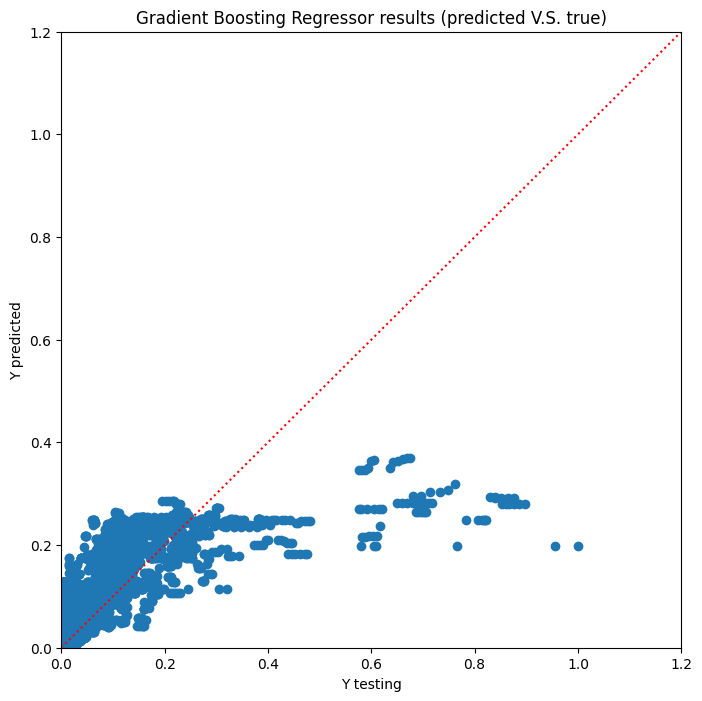

In [16]:
plt.figure(figsize=(8,8))
plt.scatter(y_test,GBRPred)
plt.xlabel("Y testing")
plt.xlim(0,1.2)
plt.ylabel("Y predicted")
plt.ylim(0,1.2)
plt.title("Gradient Boosting Regressor results (predicted V.S. true)")
plt.plot([0,10],[0,10],'r:') #questa linea aggiunge la riga
plt.show()

#### Metrics

In [17]:
gbr_metrics ={
    "mae":mean_absolute_error(y_test, GBRPred)
    ,"mse":mean_squared_error(y_test, GBRPred)
    ,"r2":r2_score(y_test, GBRPred)
}
with open('Metrics/regression metrics/gbr_metrics.json', 'w') as json_file:
    json.dump(gbr_metrics, json_file)

#### Pickle

In [18]:
with open('Pickles/regressors//GradientBoostingRegressor_parameters.pkl', 'wb') as file:
    pickle.dump(GBR.get_params(), file)

### HistGradientBoostingRegressor

In [19]:
HGBR = hgbr(random_state = 42)
HGBR = HGBR.fit(x_train,y_train)

c:\Users\ArieleBernasconi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
HGBRPred = HGBR.predict(x_test)
print("HistGradientBoostingRegressor score: ", HGBR.score(x_test,y_test))

HistGradientBoostingRegressor score:  0.8306138837447581


#### Metrics

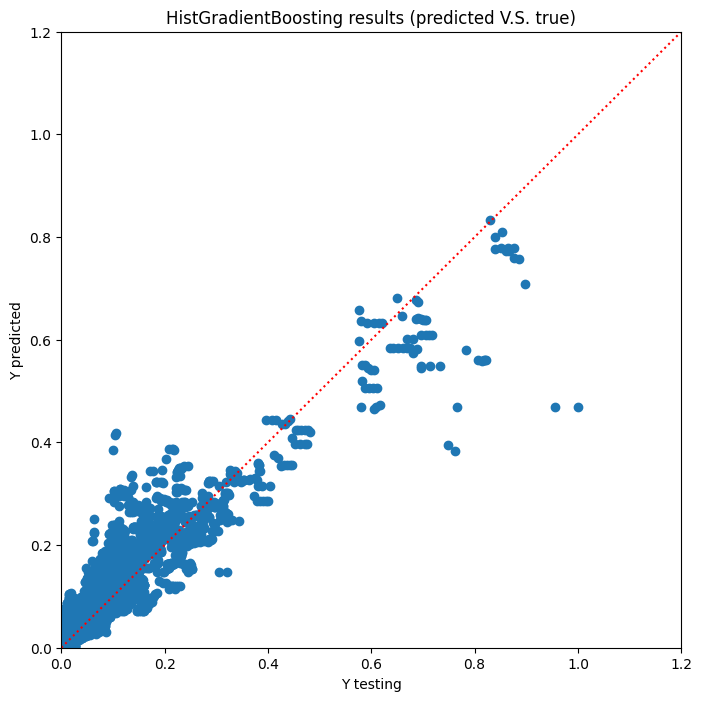

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(y_test,HGBRPred)
plt.xlabel("Y testing")
plt.xlim(0,1.2)
plt.ylabel("Y predicted")
plt.ylim(0,1.2)
plt.title("HistGradientBoosting results (predicted V.S. true)")
plt.plot([0,10],[0,10],'r:') 
plt.show()

In [22]:
hgbr_metrics ={
    "mae":mean_absolute_error(y_test, HGBRPred)
    ,"mse":mean_squared_error(y_test, HGBRPred)
    ,"r2":r2_score(y_test, HGBRPred)
}
with open('Metrics/regression metrics/hist_gbr_metrics.json', 'w') as json_file:
    json.dump(hgbr_metrics, json_file)

#### Pickle

In [23]:
with open('Pickles/regressors/HistGradientBoostingRegressor_parameters.pkl', 'wb') as file:
    pickle.dump(HGBR.get_params(), file)

### Voting Regressor

In [24]:
Voting =  VotingRegressor([('gbr',GBR),('hgbr',HGBR)])
Voting.fit(x_train,y_train)

c:\Users\ArieleBernasconi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingRegressor(estimators=[('gbr', GradientBoostingRegressor(random_state=42)),
                            ('hgbr',
                             HistGradientBoostingRegressor(random_state=42))])

In [25]:
VotingPred = Voting.predict(x_test)
print("Voting score: ", Voting.score(x_test,y_test))

Voting score:  0.7209126491933504


#### Metrics

In [26]:
voting_metrics ={
    "mae":mean_absolute_error(y_test, VotingPred)
    ,"mse":mean_squared_error(y_test, VotingPred)
    ,"r2":r2_score(y_test, VotingPred)
}
with open('Metrics/regression metrics/voting_metrics.json', 'w') as json_file:
    json.dump(voting_metrics, json_file)

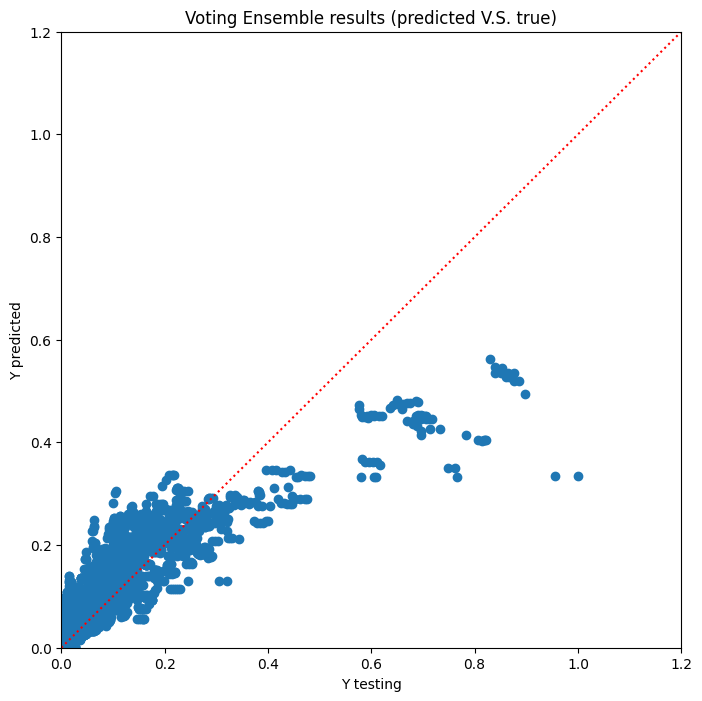

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(y_test,VotingPred)
plt.xlabel("Y testing")
plt.xlim(0,1.2)
plt.ylabel("Y predicted")
plt.ylim(0,1.2)
plt.title("Voting Ensemble results (predicted V.S. true)")
plt.plot([0,10],[0,10],'r:') #questa linea aggiunge la riga
plt.show()

#### Pickle

In [28]:
with open('Pickles/regressors/voting_parameters.pkl', 'wb') as file:
    pickle.dump(Voting.get_params(), file)